## CNN for ASL Image Classification

**Importing Libraries**

In [2]:
#importing libraries

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split,DataLoader
import torch.optim as optim

**Data Loading**

In [8]:
# setting file path
train_filepath = "../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"

# defining transforms
train_transforms = transforms.Compose([
    transforms.ToTensor()
])

#Data Loading 
train_dataset = datasets.ImageFolder(train_filepath, transform=train_transforms)
print("Train Dataset Info:\n",train_dataset)

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=64, 
                                               shuffle=True,
                                               num_workers=4)

Train Dataset Info:
 Dataset ImageFolder
    Number of datapoints: 87000
    Root location: ../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**Check Device**

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

#### **CNN 3 Convolution Layer**

*** Kernel size = 5**<br>
*** Loss Function = CrossEntropy**<br>
*** Optimizer = Adam**


In [4]:
class NN(nn.Module):
    def __init__(self):
        super(NN,self).__init__()
        self.NN = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=5,stride=1,padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2),
            
            nn.Conv2d(64,128,kernel_size=5,stride=1,padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2),
            
            nn.Conv2d(128,256,kernel_size=5,stride=1,padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2)
        )

        self.predict = nn.Sequential(
            nn.Linear(256*25*25,200),
            nn.Dropout(0.5),
            nn.BatchNorm1d(200),
            nn.Dropout(0.2),
            nn.Linear(200,29),
            nn.Softmax(dim=1)
        )
    
    def forward(self,x):
        x = self.NN(x)
        x = x.view(-1,256*25*25)
        return self.predict(x)

In [5]:
#creating a model 
model = NN()

if torch.cuda.is_available():
    model.cuda()
    
model

NN(
  (NN): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (predict): Sequential(
    (0): Linear(in_features=160000, out_features=200, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): BatchNorm1d(200, eps=1e-05,

**Initialization of HyperParameter**

In [6]:
#loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.001, weight_decay=0.0001)

In [7]:
num_epochs = 5
acc_list = []
loss_list = []
for epoch in range(num_epochs):
    correct = 0
    for batch_idx , (data,labels) in enumerate(train_dataloader):
        data = data.to(device=device)
        labels = labels.to(device= device)
        data, labels = data.cuda(), labels.cuda()
        
        #forward
        scores = model(data)
        loss = criterion(scores, labels)

        #backprop
        optimizer.zero_grad()
        loss.backward()

        #gradient descent
        optimizer.step()

        #performance
        prediction = torch.max(scores,1)[1]
    
        correct += (prediction == labels).cpu().sum().numpy()
    acc_list.append(correct/len(train_dataloader.dataset))
    loss_list.append(loss.data)
    print("Epoch :",epoch,"\tLoss :",loss.data,"\tAccuracy :",(correct/len(train_dataloader.dataset))*100)  

Epoch : 0 	Loss : tensor(2.6993, device='cuda:0') 	Accuracy : 60.773563218390805
Epoch : 1 	Loss : tensor(2.6881, device='cuda:0') 	Accuracy : 87.35977011494252
Epoch : 2 	Loss : tensor(2.6411, device='cuda:0') 	Accuracy : 90.61264367816092
Epoch : 3 	Loss : tensor(2.5223, device='cuda:0') 	Accuracy : 91.40459770114943
Epoch : 4 	Loss : tensor(2.5096, device='cuda:0') 	Accuracy : 91.7735632183908


**Plotting Accuracy and Loss while training**


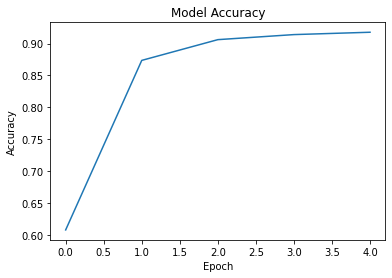

In [8]:
plt.plot(acc_list)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

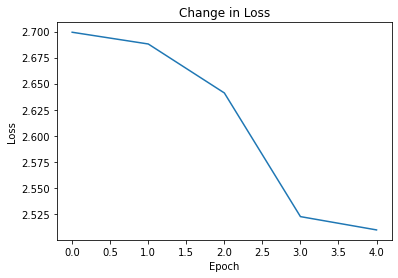

In [9]:
loss_val_list=[]
for i in range(len(loss_list)):
    loss_val_list.append(loss_list[i].cpu().detach().numpy())
    
plt.plot(loss_val_list)
plt.title('Change in Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

*** Kernel size = 3**<br>
*** Loss Function = CrossEntropy**<br>
*** Optimizer = Adam**

In [10]:
class NN1(nn.Module):
    def __init__(self):
        super(NN1,self).__init__()
        self.NN1 = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,stride=1,padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2),
            
            nn.Conv2d(64,128,kernel_size=3,stride=1,padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2),
            
            nn.Conv2d(128,256,kernel_size=3,stride=1,padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2)
        )

        self.predict = nn.Sequential(
            nn.Linear(256*25*25,200),
            nn.Dropout(0.5),
            nn.BatchNorm1d(200),
            nn.Dropout(0.2),
            nn.Linear(200,29),
            nn.Softmax(dim=1)
        )
    
    def forward(self,x):
        x = self.NN1(x)
        x = x.view(-1,256*25*25)
        return self.predict(x) 

In [11]:
#creating a model 
model1 = NN1()

if torch.cuda.is_available():
    model1.cuda()
    
model1

NN1(
  (NN1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (predict): Sequential(
    (0): Linear(in_features=160000, out_features=200, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): BatchNorm1d(200, eps=1e-0

In [12]:
#loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr= 0.001, weight_decay=0.0001)

In [13]:
num_epochs = 5
acc_list1 = []
loss_list1 = []
for epoch in range(num_epochs):
    correct = 0
    for batch_idx , (data,labels) in enumerate(train_dataloader):
        data = data.to(device=device)
        labels = labels.to(device= device)
        data, labels = data.cuda(), labels.cuda()
        
        #forward
        scores = model1(data)
        loss = criterion(scores, labels)

        #backprop
        optimizer.zero_grad()
        loss.backward()

        #gradient descent
        optimizer.step()

        #performance
        prediction = torch.max(scores,1)[1]
    
        correct += (prediction == labels).cpu().sum().numpy()
    acc_list1.append(correct/len(train_dataloader.dataset))
    loss_list1.append(loss.data)
    print("Epoch :",epoch,"\tLoss :",loss.data,"\tAccuracy :",(correct/len(train_dataloader.dataset))*100)  

Epoch : 0 	Loss : tensor(2.6698, device='cuda:0') 	Accuracy : 60.250574712643676
Epoch : 1 	Loss : tensor(2.4918, device='cuda:0') 	Accuracy : 87.57816091954022
Epoch : 2 	Loss : tensor(2.6597, device='cuda:0') 	Accuracy : 90.22298850574713
Epoch : 3 	Loss : tensor(2.5941, device='cuda:0') 	Accuracy : 90.83563218390805
Epoch : 4 	Loss : tensor(2.5196, device='cuda:0') 	Accuracy : 91.20114942528735


**Plotting Accuracy and Loss while training**


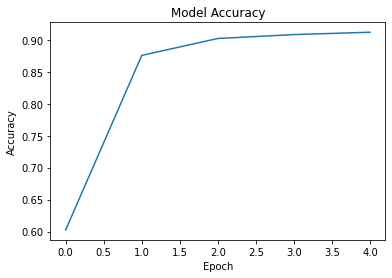

In [16]:
plt.plot(acc_list1)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

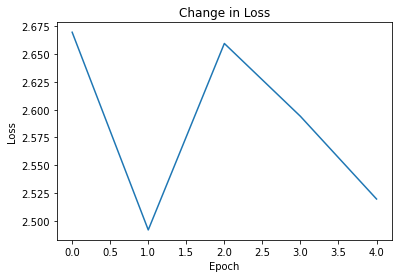

In [17]:
loss_val_list1=[]
for i in range(len(loss_list1)):
    loss_val_list1.append(loss_list1[i].cpu().detach().numpy())
    
plt.plot(loss_val_list1)
plt.title('Change in Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [18]:
test_filepath = "../input/asl-alphabet/asl_alphabet_test/"

test_transforms = transforms.Compose([
    transforms.ToTensor()
])

test_dataset = datasets.ImageFolder(test_filepath, transform=test_transforms)
print("Test Dataset Info:\n",test_dataset)

test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                               batch_size=1,shuffle=False)

Test Dataset Info:
 Dataset ImageFolder
    Number of datapoints: 28
    Root location: ../input/asl-alphabet/asl_alphabet_test/
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [19]:
import os
test_filepath = "../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/"
labels_map = {'A':0,'B':1,'C': 2, 'D': 3, 'E':4,'F':5,'G':6, 'H': 7, 'I':8, 'J':9,'K':10,'L':11, 'M': 12, 'N': 13, 'O':14, 
                'P':15,'Q':16, 'R': 17, 'S': 18, 'T':19, 'U':20,'V':21, 'W': 22, 'X': 23, 'Y':24, 'Z':25, 
                'del': 26, 'nothing': 27,'space':28}
test_labels = []
for folder_name in os.listdir(test_filepath):
    label = folder_name.replace("_test.jpg","")
    label = labels_map[label]
    test_labels.append(np.array(label))
test_labels.sort()
    
print(test_labels)

[array(0), array(1), array(2), array(3), array(4), array(5), array(6), array(7), array(8), array(9), array(10), array(11), array(12), array(13), array(14), array(15), array(16), array(17), array(18), array(19), array(20), array(21), array(22), array(23), array(24), array(25), array(27), array(28)]


In [21]:
with torch.no_grad():
    correct = 0
    pred_list =[]
    for (images,x),labels in zip(test_dataloader,test_labels):
        model1.eval()
        images = images.to(device)
#         labels = labels.to(device)
        output = model1(images)
        prediction = torch.max(output,1)[1]
        pred_list.append(prediction.cpu().numpy()[0])
        correct += (prediction.cpu().numpy()[0] == labels)
    print("Accuracy :",(correct/len(test_dataloader.dataset))*100,"%")

Accuracy : 89.28571428571429 %


In [22]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

Confusion Matrix


<Figure size 720x720 with 0 Axes>

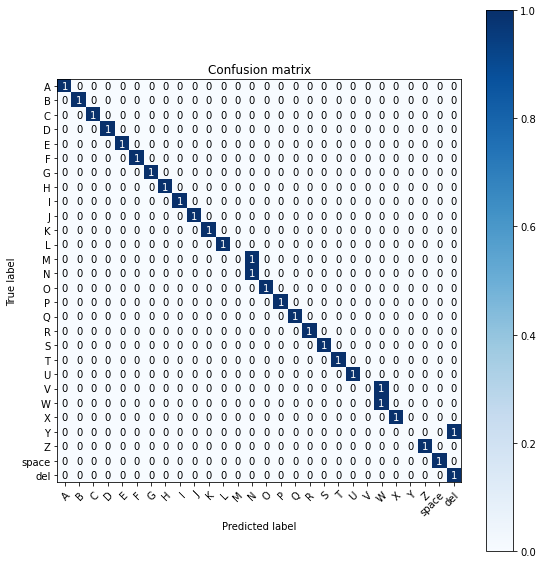

In [24]:
#confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    title = 'Confusion matrix'
        

    cm = confusion_matrix(test_labels, pred_list)

    print("Confusion Matrix")


    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)

class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y','Z', 'space', 'del' ]

plt.figure(figsize=(10,10))
plot_confusion_matrix(test_labels, pred_list, classes = class_names, title='Confusion matrix')
plt.show()
